In [1]:
import itertools
import time
import os
from collections import defaultdict

In [2]:
from dataclasses import dataclass, field
from enum import Enum
from requests import Session

In [3]:
import pickle
from xml.etree import ElementTree as ET
from typing import List, Tuple, Dict

In [100]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt

In [5]:
from tqdm import tqdm

---

In [6]:
@dataclass
class BGGElement:
    id: str


@dataclass
class Thread(BGGElement):
    subject: str
    author: str
        
    posts: List[Tuple[str, str]] = field(repr=False)
        
@dataclass
class Forum(BGGElement):
    title: str
        
    threads: List[Thread] = field(repr=False)    

---

In [7]:
@dataclass
class Thing:
    kind = 'thing'
    
    id: str
     
    
@dataclass
class ForumContainer:
    _forumlist: Dict[str, Forum] = field(init=False, repr=False, default_factory=dict)
        
    def __getitem__(self, title):
        return self._forumlist[title]
    
    def __setitem__(self, title, forum):
        if not isinstance(forum, Forum):
            raise RuntimeError('non-Forum passed')
        self._forumlist[title] = forum
        
    def load_forumlist(self, forumlist):
        for forum in forumlist:
            self[forum.title] = forum
        
    def titles(self):
        return self._forumlist.keys()
    
    def forums(self):
        return self._forumlist.values()
    
    def items(self):
        return self._forumlist.items()
    
    def __iter__(self):
        return iter(self._forumlist)


@dataclass
class BoardGame(Thing, ForumContainer):
    kind = 'boardgame'
    
    name: str
    description: str = field(repr=False)
    image: str = field(repr=False)
    yearpublished: int
        
    minage: int = field(repr=False)
        
    minplaytime: int
    maxplaytime: int
        
    minplayers: int
    maxplayers: int
    nplayers_best: str
        
    categories: List[str] = field(repr=False)
        
    def __str__(self):
        return f'''
        {self.image}
        {self.name} ({self.yearpublished})
        R: {self.minage}+
        
        {self.description}
        
        Playtime: {self.minplaytime} - {self.maxplaytime}
        Players: {self.minplayers} - {self.maxplayers} ({self.nplayers_best})
        
        {self.categories}
        '''
    
    @staticmethod
    def from_xml(item_xml):
        id_ = item_xml.get('id')
        attrs = dict()

        for attr in (
            ('name', str), ('description', str),
            ('yearpublished', int),
            ('minplaytime', int), ('maxplaytime', int),
            ('minplayers', int), ('maxplayers', int),
            ('minage', int),
        ):
            attr, cast = attr
            attrs[attr] = cast(item_xml.find(attr).get('value'))


        for attr in (
            ('image', str),
            ('description', str),
        ):
            attr, cast = attr
            attrs[attr] = cast(item_xml.find(attr).text)


        nplayers_tag = find_tag_by_attr(item_xml, 'poll', 'name', 'suggested_numplayers')
        nplayers_poll = [
            (
                result.get('numplayers'),
                int(find_tag_by_attr(result, 'result', 'value', 'Best').get('numvotes'))
            )
            for result in nplayers_tag
        ]
        attrs['nplayers_best'] = sorted(nplayers_poll, key=lambda x: x[1]).pop()[0]


        attrs['categories'] = [
            link.get('value')
            for link in find_tags_by_attr(item_xml, 'link', 'type', 'boardgamecategory')
        ]

        return BoardGame(id_, **attrs)
        
        
@dataclass(frozen=True)
class User:
    login: str

---

In [8]:
def find_tags_by_attr(xml_tree, tag, attr_key, attr_value):
    return [
        cand for cand in xml_tree.findall(tag)
        if cand.get(attr_key) == attr_value
    ]

In [9]:
def find_tag_by_attr(xml_tree, tag, attr_key, attr_value):
    return find_tags_by_attr(xml_tree, tag, attr_key, attr_value).pop()

---

In [10]:
BGG_ROOT_PATH = 'https://boardgamegeek.com/xmlapi2/'

FORUMLIST_SLEEP = 5
THREAD_SLEEP = 2

COLLECTION_SLEEP = 0.5
COLLECTION_TIMEOUT = 60


class BggSession(Session):
    def get_things(self, thing_class, ids):
        request_params = {
            'id': ','.join(ids),
            'type': thing_class.kind,
            'pagesize': 100,
        }
        response = self.get(BGG_ROOT_PATH + 'thing', params=request_params)
        if not response.ok:
            raise RuntimeError(response.content)
        
        return [thing_class.from_xml(item) for item in ET.fromstring(response.content)]
    
    def get_hotest(self, thing_class):
        response = self.get(BGG_ROOT_PATH + 'hot', params={'type': thing_class.kind})
        if not response.ok:
            raise RuntimeError(response.content)
        
        ids = [item.get('id') for item in ET.fromstring(response.content)]
            
        return self.get_things(thing_class, ids)
    
    def get_thread_posts(self, thread_id):
        response = self.get(BGG_ROOT_PATH + 'thread', params={'id': thread_id})
        if not response.ok:
            raise RuntimeError(response.content)

        tree = ET.fromstring(response.content)
        return [
            (post.get('username'), post.find('body').text)
            for post in tree.find('articles')
        ]
    
    def get_forum(self, forum_id):
        response = self.get(BGG_ROOT_PATH + 'forum', params={'id': forum_id})
        if not response.ok:
            raise RuntimeError(response.content)

        tree = ET.fromstring(response.content)
        threads = list()
        for thread in tree.find('threads'):
            time.sleep(THREAD_SLEEP)
            
            threads.append(Thread(
                thread.get('id'),
                subject=thread.get('subject'), author=thread.get('author'),
                posts=self.get_thread_posts(thread.get('id'))
            ))
        
        return Forum(forum_id, tree.get('title'), threads)
    
    def get_forumlist(self, thing_id):
        response = self.get(BGG_ROOT_PATH + 'forumlist', params={'type': 'thing', 'id': thing_id})
        if not response.ok:
            raise RuntimeError(response.content)
            
        tree = ET.fromstring(response.content)
        forums = list()
        for forum_tag in tqdm(tree, desc=f'Thing {thing_id} ForumList grep'):
            time.sleep(FORUMLIST_SLEEP)
            forums.append(self.get_forum(forum_tag.get('id')))
            
        return forums
    
    def get_user_rating(self, username, ids=None, timeout=COLLECTION_TIMEOUT):
        url = BGG_ROOT_PATH + 'collection'
        request_params = {
            'username': username,
            'stats': 1,
            'brief': 1,
        }
        if ids is not None:
            request_params['id'] = ','.join(ids)

        response = self.get(url, params=request_params)
        if response.status_code not in [200, 202]:
            raise RuntimeError(response.content)

        it = 0
        while response.status_code != 200:
            if (it * COLLECTION_SLEEP) >= COLLECTION_TIMEOUT:
                raise RuntimeError('Request timeout')

            time.sleep(COLLECTION_SLEEP)
            response = self.get(url, params=request_params)
            it += 1

        tree = ET.fromstring(response.content)
        rates = dict()
        for item in tree:
            id_ = item.get('objectid')
            stats = item.find('stats')
            if not stats:
                return {}
            
            rating = stats.find('rating').get('value')
            if rating != 'N/A':
                rates[id_] = float(rating)

        return rates

---

In [11]:
SNAPSHOT_PATH = 'snapshot'

In [24]:
bgg_session = BggSession()

In [26]:
games = bgg_session.get_hotest(BoardGame)

for i, game in enumerate(games):
    try:
        forumlist = bgg_session.get_forumlist(game.id)
        game.load_forumlist(forumlist)

        with open(os.path.join(SNAPSHOT_PATH, game.id), 'wb') as output_stream:
            pickle.dump(game, output_stream)
        print(i, game.id, 'SUCCESS', end='')
    except BaseException as exc:
        print(i, game.id, 'FAILED')

Thing 291453 ForumList grep: 100%|██████████| 10/10 [02:08<00:00, 12.86s/it]


0 291453 SUCCESS

Thing 342942 ForumList grep: 100%|██████████| 10/10 [09:33<00:00, 57.40s/it]


1 342942 SUCCESS

Thing 363204 ForumList grep: 100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


2 363204 SUCCESS

Thing 300905 ForumList grep: 100%|██████████| 10/10 [01:01<00:00,  6.16s/it]


3 300905 SUCCESS

Thing 328479 ForumList grep: 100%|██████████| 10/10 [02:55<00:00, 17.55s/it]


4 328479 SUCCESS

Thing 363369 ForumList grep: 100%|██████████| 10/10 [01:02<00:00,  6.20s/it]


5 363369 SUCCESS

Thing 246784 ForumList grep: 100%|██████████| 10/10 [05:43<00:00, 34.32s/it]


6 246784 SUCCESS

Thing 322656 ForumList grep: 100%|██████████| 10/10 [04:41<00:00, 28.19s/it]


7 322656 SUCCESS

Thing 357203 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

8 295947 SUCCESS

Thing 359871 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

9 357203 SUCCESS

Thing 359871 ForumList grep: 100%|██████████| 10/10 [02:39<00:00, 15.96s/it]


10 359871 SUCCESS

Thing 316554 ForumList grep: 100%|██████████| 10/10 [12:23<00:00, 74.40s/it]


11 316554 SUCCESS

Thing 354886 ForumList grep: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


12 354886 SUCCESS

Thing 311610 ForumList grep: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


13 311610 SUCCESS

Thing 285774 ForumList grep: 100%|██████████| 10/10 [15:30<00:00, 93.03s/it]


14 285774 SUCCESS

Thing 162886 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

15 347013 SUCCESS

Thing 227935 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

16 162886 SUCCESS

Thing 227935 ForumList grep: 100%|██████████| 10/10 [06:17<00:00, 37.70s/it]


17 227935 SUCCESS

Thing 310873 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

18 12 SUCCESS

Thing 310873 ForumList grep: 100%|██████████| 10/10 [07:03<00:00, 42.34s/it]


19 310873 SUCCESS

Thing 354892 ForumList grep: 100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


20 354892 SUCCESS

Thing 167791 ForumList grep: 100%|██████████| 10/10 [26:25<00:00, 158.50s/it]


21 167791 SUCCESS

Thing 237182 ForumList grep: 100%|██████████| 10/10 [26:35<00:00, 159.57s/it]


22 237182 SUCCESS

Thing 288080 ForumList grep: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it]


23 288080 SUCCESS

Thing 205637 ForumList grep:  80%|████████  | 8/10 [17:29<04:22, 131.24s/it]


24 205637 FAILED


Thing 84876 ForumList grep: 100%|██████████| 10/10 [11:52<00:00, 71.30s/it]


25 84876 SUCCESS

Thing 312484 ForumList grep: 100%|██████████| 10/10 [10:43<00:00, 64.32s/it]


26 312484 SUCCESS

Thing 311193 ForumList grep: 100%|██████████| 10/10 [06:38<00:00, 39.80s/it]


27 311193 SUCCESS

Thing 224517 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

28 174430 FAILED


Thing 299684 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

29 224517 SUCCESS

Thing 299684 ForumList grep: 100%|██████████| 10/10 [04:54<00:00, 29.43s/it]


30 299684 SUCCESS

Thing 266192 ForumList grep: 100%|██████████| 10/10 [12:26<00:00, 74.65s/it]


31 266192 SUCCESS

Thing 284189 ForumList grep: 100%|██████████| 10/10 [05:28<00:00, 32.81s/it]


32 284189 SUCCESS

Thing 320718 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

33 341919 SUCCESS

Thing 303669 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

34 320718 SUCCESS

Thing 352263 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

35 303669 SUCCESS

Thing 352263 ForumList grep:  30%|███       | 3/10 [12:29<29:09, 249.86s/it]


36 352263 FAILED


Thing 199792 ForumList grep: 100%|██████████| 10/10 [12:55<00:00, 77.53s/it]


37 199792 SUCCESS

Thing 318560 ForumList grep: 100%|██████████| 10/10 [03:10<00:00, 19.09s/it]


38 318560 SUCCESS

Thing 352697 ForumList grep: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


39 352697 SUCCESS

Thing 246900 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

40 331571 SUCCESS

Thing 246900 ForumList grep: 100%|██████████| 10/10 [12:48<00:00, 76.84s/it]


41 246900 SUCCESS

Thing 169786 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

42 256680 SUCCESS

Thing 167355 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

43 169786 SUCCESS

Thing 167355 ForumList grep:  30%|███       | 3/10 [06:55<16:10, 138.57s/it]


44 167355 FAILED


Thing 291457 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

45 356033 SUCCESS

Thing 291457 ForumList grep: 100%|██████████| 10/10 [11:04<00:00, 66.47s/it]


46 291457 SUCCESS

Thing 244521 ForumList grep:   0%|          | 0/10 [00:00<?, ?it/s]

47 255984 SUCCESS

Thing 244521 ForumList grep: 100%|██████████| 10/10 [09:02<00:00, 54.21s/it]

48 244521 SUCCESS

In [33]:
for i, game in enumerate([games[24], games[28], games[36], games[44]]):
    try:
        forumlist = bgg_session.get_forumlist(game.id)
        game.load_forumlist(forumlist)

        with open(os.path.join(SNAPSHOT_PATH, game.id), 'wb') as output_stream:
            pickle.dump(game, output_stream)
        print(i, game.id, 'SUCCESS', end='')
    except BaseException as exc:
        print(i, game.id, 'FAILED')

0 205637 FAILED


Thing 174430 ForumList grep:  80%|████████  | 8/10 [17:15<04:18, 129.46s/it]


1 174430 FAILED


Thing 352263 ForumList grep: 100%|██████████| 10/10 [02:20<00:00, 14.03s/it]


2 352263 SUCCESS

Thing 167355 ForumList grep:  30%|███       | 3/10 [06:53<16:04, 137.75s/it]

3 167355 FAILED


In [44]:
games.pop(24)
games.pop(43)

dict_values([Forum(id='3849597', title='Reviews'), Forum(id='3849598', title='Sessions'), Forum(id='3849599', title='General'), Forum(id='3849600', title='Rules'), Forum(id='3849601', title='Strategy'), Forum(id='3849602', title='Variants'), Forum(id='3849603', title='News'), Forum(id='3849604', title='Crowdfunding'), Forum(id='3849605', title='Play By Forum'), Forum(id='3849606', title='Organized Play')])

---

### Users Threads

In [247]:
users_threads = defaultdict(lambda: defaultdict(list))
bg_edges = defaultdict(lambda: defaultdict(int))

In [248]:
k = 1
user2id = dict()

for game in games:
    for fname, forum in game.items():
        for thread in forum.threads:
            users = set(post[0] for post in thread.posts if post[0])
            for user in users:
                users_threads[user][game.id] += [thread.id]
                
            for u1, u2 in itertools.product(users, repeat=2):
                if u1 == u2:
                    continue
                if u1 > u2:
                    u1, u2 = u2, u1
                    
                if u1 not in user2id:
                    user2id[u1] = k
                    k += 1
                if u2 not in user2id:
                    user2id[u2] = k
                    k += 1
                bg_edges[game.id][(user2id[u1], user2id[u2])] += 1

In [76]:
users_threads['The_EyE']

defaultdict(list,
            {'291453': ['2684340'],
             '328479': ['2736003'],
             '284189': ['2850465', '2850465'],
             '291457': ['2460221']})

In [239]:
bg_edges['244521']

defaultdict(int,
            {(16263, 249): 2,
             (16264, 16265): 2,
             (2971, 16264): 2,
             (16264, 16266): 2,
             (16264, 10471): 2,
             (16264, 16267): 2,
             (16264, 8650): 2,
             (2971, 16265): 2,
             (16265, 16266): 2,
             (16265, 10471): 2,
             (16265, 16267): 2,
             (16265, 8650): 2,
             (2971, 16266): 2,
             (2971, 10471): 4,
             (2971, 16267): 2,
             (2971, 8650): 2,
             (10471, 16266): 2,
             (16267, 16266): 2,
             (8650, 16266): 2,
             (16267, 10471): 2,
             (10471, 8650): 2,
             (16267, 8650): 2,
             (16268, 16269): 2,
             (7038, 85): 2,
             (7038, 8331): 2,
             (8331, 85): 2,
             (6788, 968): 4,
             (6788, 906): 2,
             (6788, 10924): 4,
             (6788, 2690): 2,
             (6788, 366): 4,
             (6788, 2579): 

---

In [180]:
bgg_session = BggSession()

In [181]:
bgg_session.get_user_rating('eldmitro', ids)

{'246900': 10.0, '237182': 9.0, '162886': 9.9, '167791': 7.0}

---

### Users Ratings

In [183]:
ids = [game.id for game in games]

In [185]:
users_rating = dict()
for username in tqdm(users_threads, desc='User rating collection'):
    rates = bgg_session.get_user_rating(username, ids)
    users_rating[username] = rates

User rating collection:   1%|          | 117/16752 [01:50<4:22:52,  1.05it/s]


AttributeError: 'NoneType' object has no attribute 'find'

---

In [ ]:
bg_id2name = dict()
for game in games:
    bg_id2name[game.id] = game.name

---

In [269]:
SNAPSHOT_PATH

'snapshot'

In [12]:
def dump_struct(obj, filename):
    with open(SNAPSHOT_PATH + '/' + filename, 'wb') as output_stream:
        pickle.dump(obj, output_stream)
        
def load_struct(filename):
    with open(SNAPSHOT_PATH + '/' + filename, 'rb') as input_stream:
        return pickle.load(input_stream)

---

dump_struct(dict(users_threads), 'users_threads')

dump_struct(dict(bg_edges), 'bg_edges')

In [14]:
users_threads = load_struct('_users_threads')
bg_edges = load_struct('_bg_edges')

In [47]:
filename

'12'

In [48]:
SNAPSHOT_PATH

'snapshot'

In [49]:
games = list()
for filename in os.listdir(SNAPSHOT_PATH):
    if filename.startswith('_'):
        continue
        
    games.append(load_struct(filename))

---

In [64]:
games[-2]

BoardGame(id='237182', name='Root', yearpublished=2018, minplaytime=60, maxplaytime=90, minplayers=2, maxplayers=4, nplayers_best='4')

In [65]:
G = nx.cubical_graph()
G.add_edges_from(bg_edges['237182'].keys())
# for key in bg_edges:
#     G.add_edges_from(bg_edges[key].keys())

In [66]:
G.number_of_edges()

85104

In [67]:
G.number_of_nodes()

1922

In [68]:
np.mean([d for _, d in G.degree()])

88.55775234131113

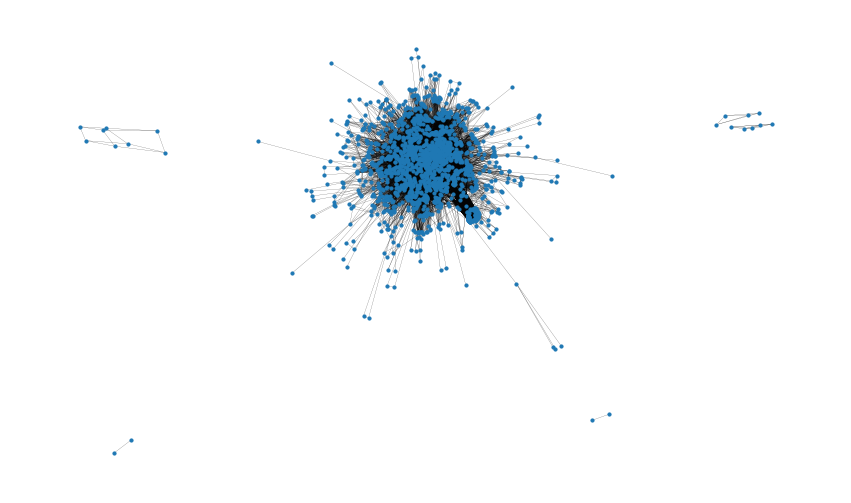

In [69]:
pos = nx.spring_layout(G, iterations=20, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
ax.axis('off')
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

---

In [72]:
G = nx.cubical_graph()
for key in bg_edges:
    G.add_edges_from(bg_edges[key].keys())

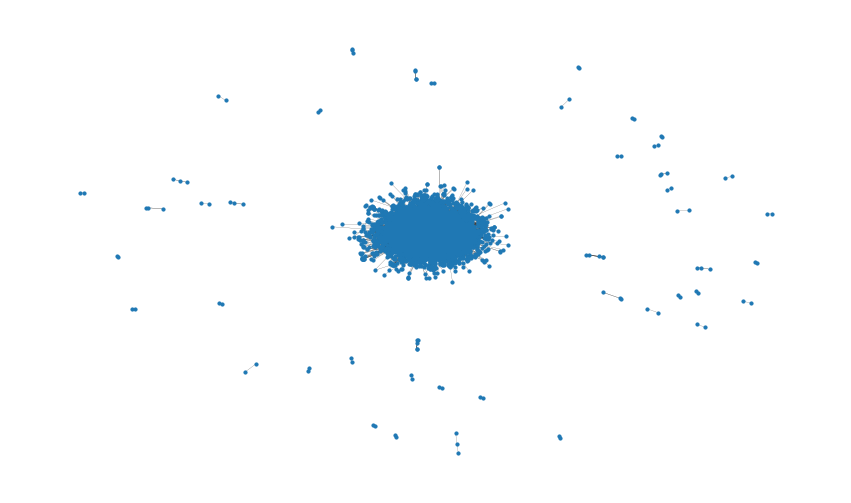

In [73]:
pos = nx.spring_layout(G, iterations=20, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
ax.axis('off')
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

---

---

In [78]:
games_slice = ['291457', '266192', '169786', '167791', '237182', '162886']

In [ ]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

In [98]:
font = {
    'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22
}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


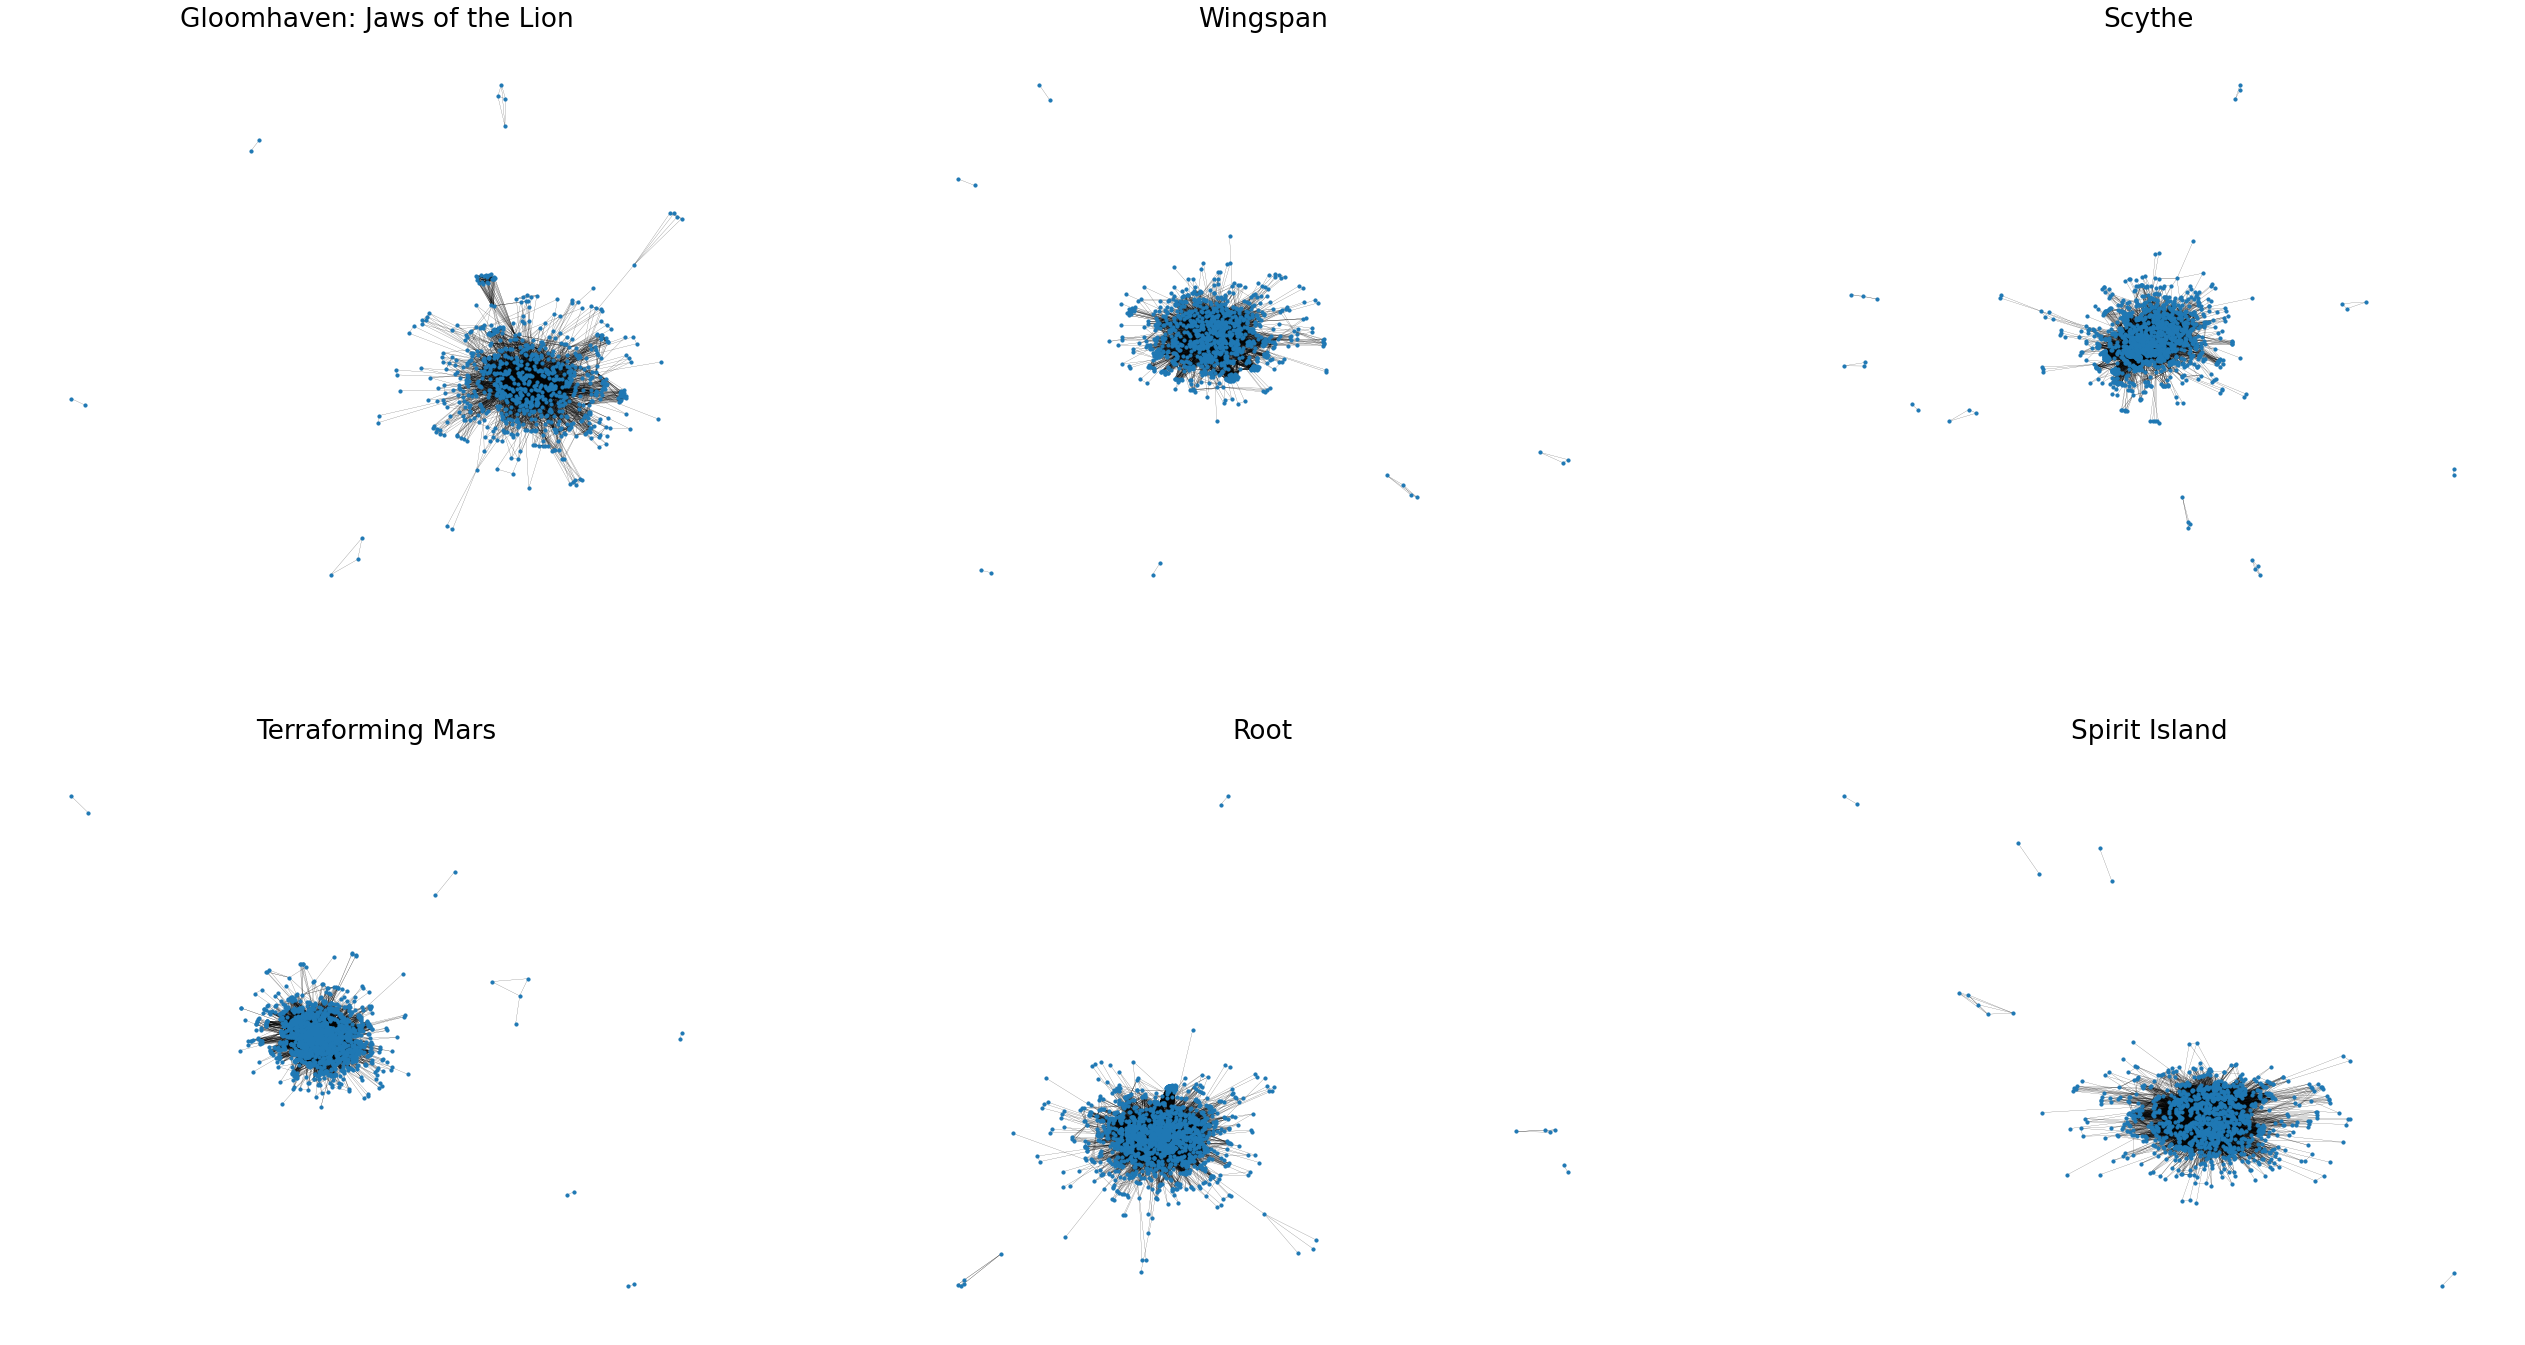

In [99]:
fig, axs = plt.subplots(2, 3, figsize=(15 * 3, 12 * 2))
for game, ax in zip(games_slice, axs.flatten()):
    G = nx.Graph()
    G.add_edges_from(bg_edges[game].keys())
    pos = nx.spring_layout(G, iterations=20, seed=443)
    ax.axis('off')
    
    ax.set_title(bg_id2name[game])
    
    nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)